# Computing product ease of assembly with NLP
In this notebook we'll be finding the best word embedding for the job:
1. Reading in some labeled data
2. Preprocess the data for each intended model
3. Splitting the data into test/train sets   
4. Embed a few models on the train set (BoW, TF-IDF, word2vec, BERT is too big)
5. Logistic regression on the train set (test data)
6. Evaluate output (confusion matrix and other checks)
7. Use VADER to get an assembly rating
8. Evaluate output 
9. Label ALL review sentences
10. Get subtopics with LDA

In [1]:
# Import cell
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import pickle
import csv
import random
import joblib

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

/Users/kolbt/insight/insight_env/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Products that I've scraped data for
product_set = ( 'office+chair',
                'office+desk',
                'kitchen+table',
                'living+room+couch',
                'end+table',
                'bed+frame',
                'crib',
                'bookcase',
                'coffee+table')

## 1. Read in the labeled data


In [3]:
# The directory for my data
data_directory = "../data/"

In [4]:
# Let's import our labeled sentence dataset
labeled_xls = data_directory + "sentence_rating.xlsx"
labeled_sentences = pd.read_excel(labeled_xls, sheet_name='Sheet1')
labeled_sentences.dropna(subset = ["assembly"], inplace=True)

assembly_sentences = sum(labeled_sentences['assembly'].tolist())
total_sentences = len(labeled_sentences['assembly'])
non_assembly_sentences = total_sentences - assembly_sentences
default_accuracy = float(non_assembly_sentences) / len(labeled_sentences['assembly'])

print("Number of assembly-related sentences:", assembly_sentences)
print("Default accuracy:", round(default_accuracy, 2))

display(labeled_sentences)

Number of assembly-related sentences: 162.0
Default accuracy: 0.84


,Sentence,assembly,rate_ease,quality,rate_quality
0,Disappointed.,0.0,NaN,0.0,NaN
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0
...,...,...,...,...,...
994,"I am 6'1"" 215 pounds.",0.0,NaN,NaN,NaN
995,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN
996,"All in all, it's made my work day a lot more p...",0.0,NaN,NaN,NaN
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN


In [5]:
# We are going to undersample the data to balance out the labels
import random
seed = 42
random.seed(seed)

# How much do we want to balance the data (1.0 is a completely balanced data set)
under_sample_factor = 2.0

assembly_indices = []
regular_indices = []

# Get a list of all the assembly sentences
for i in range(0, len(labeled_sentences['assembly'])):
    if labeled_sentences['assembly'].iloc[i] == 1.0:
        assembly_indices.append(i)
    # Maybe this biases towards shorter sentences?
    else:
        regular_indices.append(i)
        
# Get a random sample of regular sentences
assembly_indices = np.sort(assembly_indices)
# regular_balanced = np.sort(random.sample(regular_indices, int(assembly_sentences)))
regular_balanced = np.sort(random.sample(regular_indices, int(assembly_sentences * under_sample_factor)))

# Check to make sure all looks good
print(len(assembly_indices))
print(len(regular_balanced))
# print(assembly_indices)
# print(regular_balanced)

# Now let's make a new dataframe from these indices
df_list = []
for i in assembly_indices:
    df_list.append([])
    df_list[-1].append(labeled_sentences['Sentence'].iloc[i])
    df_list[-1].append(labeled_sentences['assembly'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_ease'].iloc[i])
    df_list[-1].append(labeled_sentences['quality'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_quality'].iloc[i])
    
for i in regular_balanced:
    df_list.append([])
    df_list[-1].append(labeled_sentences['Sentence'].iloc[i])
    df_list[-1].append(labeled_sentences['assembly'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_ease'].iloc[i])
    df_list[-1].append(labeled_sentences['quality'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_quality'].iloc[i])
    
# Convert this to a dataframe
under_sampled = pd.DataFrame(df_list, columns =['sentence', 'assembly', 'rate_ease', 'quality', 'rate_quality']) 
display(under_sampled)

162
324


,sentence,assembly,rate_ease,quality,rate_quality
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN
...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN


## 2. Preprocess the text for each embedding type

## BoW: 
lowercase, no tags, no special characters, no punctuation, no extra whitespace, no stopwords

In [6]:
# Some aspect of preprocessing is removing a few words I'd rather keep
import gensim.parsing.preprocessing as gpp

test_sentence = "These parts work great!"

# This is the BoW filter for reference
try_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.strip_short,
              gpp.stem_text,
              gpp.remove_stopwords]

# Preprocess step-by-step
in_filter = []
for i in try_filter:
    in_filter.append(i)
    out = gpp.preprocess_string(test_sentence, in_filter)
    print(out)

stops = gpp.STOPWORDS
# The word "part" is in our list of stopwords
if "part" in stops:
    print("part")

['these', 'parts', 'work', 'great!']
['these', 'parts', 'work', 'great!']
['these', 'parts', 'work', 'great!']
['these', 'parts', 'work', 'great']
['these', 'parts', 'work', 'great']
['these', 'parts', 'work', 'great']
['these', 'parts', 'work', 'great']
['these', 'part', 'work', 'great']
['work', 'great']
part


In [7]:
# Make a custom stopword list based off of gensims stopwords
stops = list(gpp.STOPWORDS)
# Parts is in gensim's stopword list
if "part" in stops:
    print("part")
# Remove it
stops.remove("part")
# Make sure it is no longer a stopword
if "part" in stops:
    print("part")

part


In [8]:
# Process the data for BoW
sample = under_sampled["sentence"].iloc[2]
print("Bag of words cleaning:")
print("Input:", sample)

# What do we want to remove from our sentences?
my_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.strip_short,
              gpp.stem_text]

# Given what output I've seen there are a couple more words I'd like removed 
custom_remove = ["wa", "thi", "veri", "ar", "thei", "like", "realli"]

def bow_clean(sentence, in_filter):
    
    # Apply gensim filter
    out = gpp.preprocess_string(sentence, in_filter)
    
    # Remove additional undesirable words
    for i in reversed(out):
        if i in custom_remove:
            out.remove(i)
            
    # Remove custom stopwords
    for i in reversed(out):
        if i in stops:
            out.remove(i)
            
    # Reform sentences
    reform = ""
    for i in out:
        reform += i
        reform += " "
    return reform

out = bow_clean(sample, my_filter)
print("Output:", out)

# Apply the cleaning functions
under_sampled['bow'] = under_sampled['sentence'].apply(lambda x: bow_clean(x, my_filter))

display(under_sampled)

Bag of words cleaning:
Input: Super comfortable and easy to put together (Took about 10minutes).
Output: super comfort easi togeth took minut 


,sentence,assembly,rate_ease,quality,rate_quality,bow
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,easi togeth clear instruct particularli label ...
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,deliveri fast assembl easi screw leg
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,super comfort easi togeth took minut
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,took coupl hour assembl chair
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,simpl instruct easi understand
...,...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN,care assembl came tini nick splinter wood noti...
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN,braket goe hold desk togetehr doesnt fit long
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN,mai bui anoth desk storag
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,great tabl sturdi afford price


## word2vec:
BoW + tokenized

In [9]:
# I'm going to use gensim for this
sample = under_sampled["sentence"].iloc[2]
print("word2vec cleaning:")
print("")
print("Input", sample)
print("")

def preprocess_w2v(sentence, in_filter):
    
    # Apply gensim filter
    out = gpp.preprocess_string(sentence, in_filter)
    
    # Remove additional undesirable words
    for i in reversed(out):
        if i in custom_remove:
            out.remove(i)
            
    # Remove custom stopwords
    for i in reversed(out):
        if i in stops:
            out.remove(i)
    
    # Return the tokenized words
    return out
    
out = preprocess_w2v(sample, my_filter)
print("Output:", out)
print("")

# Apply the cleaning functions
under_sampled['w2v'] = under_sampled['sentence'].apply(lambda x: preprocess_w2v(x, my_filter))
display(under_sampled)

word2vec cleaning:

Input Super comfortable and easy to put together (Took about 10minutes).

Output: ['super', 'comfort', 'easi', 'togeth', 'took', 'minut']



,sentence,assembly,rate_ease,quality,rate_quality,bow,w2v
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,easi togeth clear instruct particularli label ...,"[easi, togeth, clear, instruct, particularli, ..."
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,deliveri fast assembl easi screw leg,"[deliveri, fast, assembl, easi, screw, leg]"
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,super comfort easi togeth took minut,"[super, comfort, easi, togeth, took, minut]"
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,took coupl hour assembl chair,"[took, coupl, hour, assembl, chair]"
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,simpl instruct easi understand,"[simpl, instruct, easi, understand]"
...,...,...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN,care assembl came tini nick splinter wood noti...,"[care, assembl, came, tini, nick, splinter, wo..."
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN,braket goe hold desk togetehr doesnt fit long,"[braket, goe, hold, desk, togetehr, doesnt, fi..."
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN,mai bui anoth desk storag,"[mai, bui, anoth, desk, storag]"
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,great tabl sturdi afford price,"[great, tabl, sturdi, afford, price]"


## 3. Split the data

In [10]:
# We're splitting 70/30 for now
split = 0.2

# Perform the same split for each embedding type
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(under_sampled['bow'], 
                                                                    under_sampled['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)
# And for w2v
x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = train_test_split(under_sampled['w2v'], 
                                                                    under_sampled['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)

# Let's hold everything in one data frame
train_frame = {'x_bow': x_train_bow, 'y_bow': y_train_bow, 'x_w2v': x_train_w2v, 'y_w2v': y_train_w2v}
train_data = pd.DataFrame(train_frame)

# And for test
test_frame = {'x_bow': x_test_bow, 'y_bow': y_test_bow, 'x_w2v': x_test_w2v, 'y_w2v': y_test_w2v}
test_data = pd.DataFrame(test_frame)

# Take a peak to make sure all is well
display(train_data)

,x_bow,y_bow,x_w2v,y_w2v
132,chair easi assembl ha good height adjust goe l...,1.0,"[chair, easi, assembl, ha, good, height, adjus...",1.0
25,pro easi assembl sturdi look nice offer adequ ...,1.0,"[pro, easi, assembl, sturdi, look, nice, offer...",1.0
222,overal extrem happi purchas recommend tabl any...,0.0,"[overal, extrem, happi, purchas, recommend, ta...",0.0
316,husband work home multipl occas ha tri steal,0.0,"[husband, work, home, multipl, occas, ha, tri,...",0.0
294,feel sturdi,0.0,"[feel, sturdi]",0.0
...,...,...,...,...
106,everyth includ direct clear,1.0,"[everyth, includ, direct, clear]",1.0
270,pai,0.0,[pai],0.0
348,love qualiti look,0.0,"[love, qualiti, look]",0.0
435,overal chair built support desk jockei,0.0,"[overal, chair, built, support, desk, jockei]",0.0


## 4. Embed the models

## BoW: Count Vectorized

In [11]:
# We'll start with BoW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate the count vectorizer 
# -n-grams of length 1 and 2
# -ignore words that are in more than 50% of sentences
# -ignore words that are in fewer than 0.5% of sentences
# cv = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=0.005)
min_occur = 2
max_occur = 0.5
ngrams = (1, 1)
cv = CountVectorizer(ngram_range=ngrams, max_df=max_occur, min_df=min_occur)

# Make the x train a list
bow_x_train_list = train_frame['x_bow'].tolist()

# Feed our sentences to the count vectorizer
count_data = cv.fit_transform(bow_x_train_list)

# Print the number of words being used
print(len(cv.get_feature_names()))
# A list of the words
bow_words = cv.get_feature_names()
# A dataframe of the train data
cv_df = pd.DataFrame(count_data.toarray(), columns = cv.get_feature_names())
display(cv_df)

313


,100,abl,absolut,actual,adjust,afford,air,alreadi,amaz,amazon,...,went,wheel,wife,wobbl,won,wood,work,worth,wrap,year
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# %%capture
# Print the feature names (for use on AWS Lambda)
print(bow_words)

['100', 'abl', 'absolut', 'actual', 'adjust', 'afford', 'air', 'alreadi', 'amaz', 'amazon', 'ani', 'apart', 'area', 'arm', 'armrest', 'arriv', 'assembl', 'attach', 'awesom', 'base', 'beat', 'beauti', 'becaus', 'bed', 'bedroom', 'befor', 'bench', 'better', 'big', 'bigger', 'bit', 'black', 'board', 'bolt', 'bought', 'box', 'breath', 'bubbl', 'bug', 'bui', 'build', 'built', 'came', 'cat', 'chair', 'cheap', 'chose', 'clear', 'coffe', 'color', 'come', 'comfort', 'compani', 'complet', 'comput', 'condit', 'confus', 'corner', 'couch', 'couldn', 'coupl', 'cover', 'cushion', 'dai', 'damag', 'daughter', 'deep', 'definit', 'deliv', 'deliveri', 'design', 'desk', 'desktop', 'didnt', 'dimens', 'direct', 'disappoint', 'doe', 'doesnt', 'dog', 'dollar', 'dont', 'door', 'drawer', 'drill', 'dure', 'eas', 'easi', 'easier', 'easili', 'email', 'end', 'especi', 'everi', 'everyon', 'everyth', 'exactli', 'excess', 'expect', 'extra', 'extrem', 'fabric', 'fall', 'fast', 'feel', 'fine', 'firm', 'fit', 'fix', 'foll

In [13]:
# Let's get the counts of these words for the test set as well
bow_test_vectors = []
for sentence in test_frame['x_bow']:
    #sentence_tokens = nltk.word_tokenize(sentence)
    sentence_tokens = []
    gs_tokenizer = gensim.utils.tokenize(sentence)
    for iii in gs_tokenizer:
        sentence_tokens.append(iii)
    sent_vec = []
    for token in bow_words:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    bow_test_vectors.append(sent_vec)

## TF-IDF

In [14]:
# We can also use TFIDF to get sentence vectors
tfidf = TfidfVectorizer(ngram_range=ngrams, max_df=max_occur, min_df=min_occur)
tfidf_count = tfidf.fit_transform(bow_x_train_list)
tfidf_words = tfidf.get_feature_names()
tfidf_vocabulary = tfidf.vocabulary_
print(tfidf_count.shape)

# A dataframe of the train data
tfidf_df = pd.DataFrame(tfidf_count.toarray(), columns = tfidf_words)
display(tfidf_df)

(388, 313)


,100,abl,absolut,actual,adjust,afford,air,alreadi,amaz,amazon,...,went,wheel,wife,wobbl,won,wood,work,worth,wrap,year
0,0.0,0.0,0.0,0.0,0.328016,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.37365,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.246715,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.217371,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.352050,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
384,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [15]:
# Get TF-IDF for the test set using the vocab we've made
tfidf_x_test_list = test_frame['x_bow'].tolist()
tfidf_test_vectors = tfidf.transform(tfidf_x_test_list)
print(tfidf_test_vectors[1])

  (0, 161)	1.0


## w2v

In [16]:
# The parameters for the w2v model
# size      : should be low (~100) if you don't have much data and large (~1000) if you have a lot of data
# window    : is how many words to search for a keyword
# min_count : the model will ignore words which do not appear at least this frequently 
trained_w2v = gensim.models.Word2Vec(train_frame['x_w2v'], min_count=2, window=5, size=100)

# Show the vocab
trained_w2v.wv.vocab

# Just a few things to show what we can do with w2v
target = 'assembl'
trained_w2v.wv.most_similar(positive=target)

[('couch', 0.274578332901001),
 ('bubbl', 0.26409757137298584),
 ('neatli', 0.24332872033119202),
 ('read', 0.23832997679710388),
 ('becaus', 0.23125043511390686),
 ('bit', 0.23051457107067108),
 ('person', 0.22962990403175354),
 ('desk', 0.2234586775302887),
 ('sand', 0.21858349442481995),
 ('set', 0.2153114676475525)]

In [17]:
# def word_averaging(w2v, sentence):
#     # remove out-of-vocabulary words
#     words = [word for word in sentence if word in w2v.vocab]
#     if len(words) >= 1:
#         return np.mean(w2v[words], axis=0)
#     else:
#         return []
# 
# sample = train_data['x_w2v'].iloc[0]
# print(sample)
# mean = word_averaging(trained_w2v.wv, sample)
# print(mean)

In [18]:
# w2v comes with an additional step: averaging the word vectors over sentences
def word_averaging(wv, sentence):
    all_words, mean = set(), []
    # Loop through each word in the sentence
    for word in sentence:
        if word in wv.vocab:
            # This works for data-trained
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    # Check if mean is empty
    if not mean:
        return [0. for i in range(wv.vector_size)]
        
    # Creat a list that sums the vectors
    sum_vec = [0. for i in range(len(mean[0]))]
    for i in range(0, len(mean)):
        for j in range(0, len(mean[0])):
            sum_vec[j] += mean[i][j]
            
    # Divide by the number of vectors that were added
    mean_vec = [ i / float(len(mean)) for i in sum_vec]
            
    # Get the magnitude
    mag = 0.
    for i in sum_vec:
        mag += (i**2.)
        
    # Compute the unit vector
    mean_unit_vec = [ i / float(mag**0.5) for i in mean_vec ]

    return mean_unit_vec

In [19]:
# Compute the average word vector for each sentence
train_sentence_means = []
for i in range(0, len(train_frame['x_w2v'])):
    sentence_mean = word_averaging(trained_w2v.wv, train_frame['x_w2v'].iloc[i])
    train_sentence_means.append(sentence_mean)
    # Make sure the vectors are the correct length
    #print(len(train_sentence_means[-1]))
    
test_sentence_means = []
for i in range(0, len(test_frame['x_w2v'])):
    sentence_mean = word_averaging(trained_w2v.wv, test_frame['x_w2v'].iloc[i])
    test_sentence_means.append(sentence_mean)
    # Make sure the vectors are the correct length
    #print(len(test_sentence_means[-1]))


## 5. Regress the models

## BoW

In [20]:
# We'll use logistic regression
bow_regression = LogisticRegression(n_jobs=1)
# Get count vector lists for each sentence
bow_x = cv_df.values.tolist()
bow_y = train_frame['y_bow'].tolist()
# This give our logistic regression fit to the training data
bow_regression = bow_regression.fit(bow_x, bow_y)

# We can see how the test data matches up by predicting y from the x vectors
bow_predict = bow_regression.predict(bow_test_vectors)
print(sum(bow_predict))
real_y = test_frame['y_bow'].tolist()
print(sum(real_y))

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(bow_predict)):
    if bow_predict[i] == real_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(real_y) * 100.
        
print(f"Model accuracy: {round(percent_correct, 1)}%")

33.0
35.0
Model accuracy: 93.9%


In [21]:
# Compute the F1 score
bow_f1 = f1_score(real_y, bow_predict)
print(round(bow_f1, 2))

0.91


In [22]:
# Save the model
logreg_out = '../models/BoW_logistic_regression.pkl'
joblib.dump(bow_regression, logreg_out)

['../models/BoW_logistic_regression.pkl']

## TF-IDF

In [23]:
# Let's fit the model
tfidf_regression = LogisticRegression(n_jobs=1)
# Get count vector lists for each sentence
tfidf_x = tfidf_df.values.tolist()
tfidf_y = train_frame['y_bow'].tolist()
# This give our logistic regression fit to the training data
tfidf_regression = tfidf_regression.fit(tfidf_x, tfidf_y)

# We can see how the test data matches up by predicting y from the x vectors
tfidf_predict = tfidf_regression.predict(tfidf_test_vectors)
print(sum(tfidf_predict))
real_y = test_frame['y_bow'].tolist()
print(sum(real_y))

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(tfidf_predict)):
    if tfidf_predict[i] == real_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(real_y) * 100.
        
print(f"Model accuracy: {round(percent_correct, 1)}%")

30.0
35.0
Model accuracy: 90.8%


## w2v

In [24]:
# We'll use logistic regression
w2v_regression = LogisticRegression(n_jobs=1)
# Get count vector lists for each sentence
w2v_x = train_sentence_means
w2v_y = train_frame['y_w2v'].tolist()
# This give our logistic regression fit to the training data
w2v_regression = w2v_regression.fit(w2v_x, w2v_y)

# We can see how the test data matches up by predicting y from the x vectors
w2v_predict = w2v_regression.predict(test_sentence_means)
print(sum(w2v_predict))
real_y = test_frame['y_w2v'].tolist()
print(sum(real_y))

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(w2v_predict)):
    if w2v_predict[i] == real_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(real_y) * 100.
        
print(f"Model accuracy: {round(percent_correct, 1)}%")

8.0
35.0
Model accuracy: 70.4%


## 6. Evaluate

## BoW

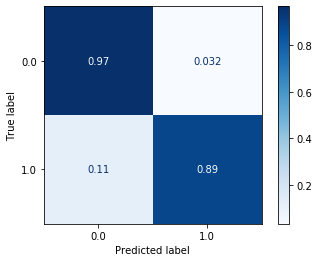

In [25]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_bow = confusion_matrix(real_y, bow_predict)
disp = plot_confusion_matrix(bow_regression, bow_test_vectors, real_y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()


## TF-IDF

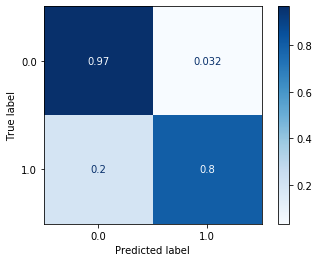

In [26]:
disp = plot_confusion_matrix(tfidf_regression, tfidf_test_vectors, real_y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()

## w2v

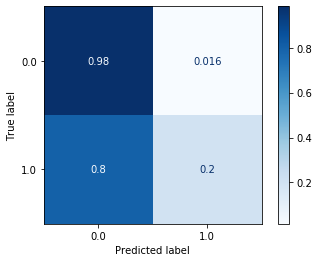

In [27]:
disp = plot_confusion_matrix(w2v_regression, test_sentence_means, real_y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()

## 7. Analyze sentiment with VADER

In [28]:
# Okay, now we layer a sentiment analysis on this
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment(sentence, decimal=0):
    '''Assign sentiment to any give sentence using VADER'''
    # Instantiate the sentiment analyzer
    sentiment = SentimentIntensityAnalyzer()
    # Get the sentiment dictionary for my sentence
    sentiment_dict = sentiment.polarity_scores(sentence) 
    # Output the compound sentiment (between [-1, 1])
    out = sentiment_dict['compound']
    # Renormalize this to be [1, 5]
    stars = (out * 2.) + 3.
    return round(stars, decimal)

In [29]:
# Let's get a column of sentiment
labeled_sentences['vader_rating'] = labeled_sentences['Sentence'].apply(lambda x: get_sentiment(x))
labeled_sentences['float_vader_rating'] = labeled_sentences['Sentence'].apply(lambda x: get_sentiment(x, 3))

In [30]:
display(labeled_sentences)

,Sentence,assembly,rate_ease,quality,rate_quality,vader_rating,float_vader_rating
0,Disappointed.,0.0,NaN,0.0,NaN,2.0,2.047
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN,3.0,3.000
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,5.0,4.718
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN,4.0,4.274
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0,3.0,3.403
...,...,...,...,...,...,...,...
994,"I am 6'1"" 215 pounds.",0.0,NaN,NaN,NaN,3.0,3.000
995,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,4.0,4.318
996,"All in all, it's made my work day a lot more p...",0.0,NaN,NaN,NaN,5.0,4.644
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN,5.0,4.682


## 8. Evaluate VADER performance

In [31]:
# We'll drop all rows that don't have an ease of assembly rating
only_labeled = labeled_sentences.dropna(subset = ["rate_ease"])
only_labeled['rate_diff'] = only_labeled['rate_ease'] - only_labeled['vader_rating'] 
display(only_labeled)

,Sentence,assembly,rate_ease,quality,rate_quality,vader_rating,float_vader_rating,rate_diff
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,5.0,4.718,0.0
6,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,3.0,2.795,2.0
17,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,5.0,4.756,0.0
28,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,3.0,3.000,0.0
30,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,4.0,3.985,1.0
...,...,...,...,...,...,...,...,...
987,My boyfriend said it will be relative easy to ...,1.0,3.0,NaN,NaN,4.0,3.881,-1.0
989,"Great chair, easy assembly.",1.0,5.0,NaN,NaN,5.0,4.581,0.0
993,I would not have ran into this issue if it cam...,1.0,1.0,NaN,NaN,3.0,3.000,-2.0
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN,5.0,4.682,0.0


In [32]:
# Let's bin this a bit: either negative or positive
def bin_sentiment(rating):
    # Positive
    if rating > (11./3.):
        return 2
    # Negative
    elif rating < (7./3.):
        return 0
    # Neutral
    else:
        return 1

# Apply the cleaning functions
only_labeled['bin_rating'] = only_labeled['rate_ease'].apply(lambda x: bin_sentiment(x))
only_labeled['bin_rating_vader'] = only_labeled['vader_rating'].apply(lambda x: bin_sentiment(x))

# Let's make a new df of just this
cols = ['bin_rating', 'bin_rating_vader']
out_one = only_labeled[cols]
# Remove all neutral ratings
out_two = out_one[out_one.bin_rating != 1]
binned_ratings = out_two[out_two.bin_rating_vader != 1]

display(binned_ratings)

,bin_rating,bin_rating_vader
2,2,2
17,2,2
30,2,2
33,2,2
42,2,2
...,...,...
971,0,2
982,2,2
984,2,2
989,2,2


In [33]:
from scipy import stats
# Let's look at the differences in distribution here
labeled_rating = only_labeled['rate_ease'].tolist()
vader_rating = only_labeled['vader_rating'].tolist()
vader_rating_float = only_labeled['float_vader_rating'].tolist()
bin_labeled_rating = binned_ratings['bin_rating'].tolist()
bin_vader_rating = binned_ratings['bin_rating_vader'].tolist()

# What is the average of each set
labeled_mean = np.mean(labeled_rating)
labeled_mode = stats.mode(labeled_rating)
labeled_median = np.median(labeled_rating)
vader_mean = np.mean(vader_rating_float)
vader_mode = stats.mode(vader_rating_float)
vader_median = np.median(vader_rating_float)
print(labeled_mean)
print(labeled_mode[0][0])
print(labeled_median)
print("")
print(vader_mean)
print(vader_mode[0][0])
print(vader_median)

3.8209876543209877
5.0
4.0

3.5135925925925933
3.0
3.701


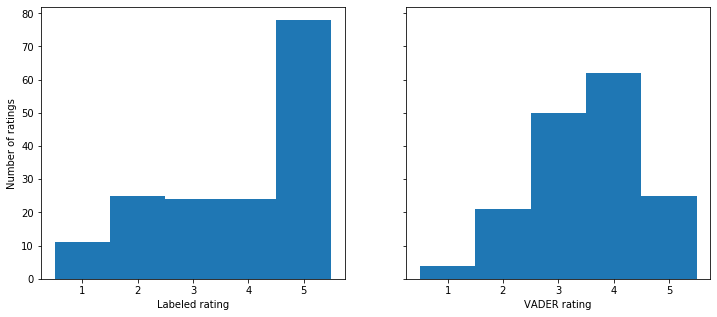

In [34]:
# Let's get a distribution of the labeled data and the VADER predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
bins = np.arange(1,7,1)-0.5
ax[0].hist(labeled_rating, bins=bins)
# ax.set_xlim(-3, 3)
ax[0].set_xlabel(r'Labeled rating')
ax[0].set_ylabel(r'Number of ratings')
ax[1].set_xlabel(r'VADER rating')

# Now plot the VADER data
ax[1].hist(vader_rating, bins=bins)
plt.show()

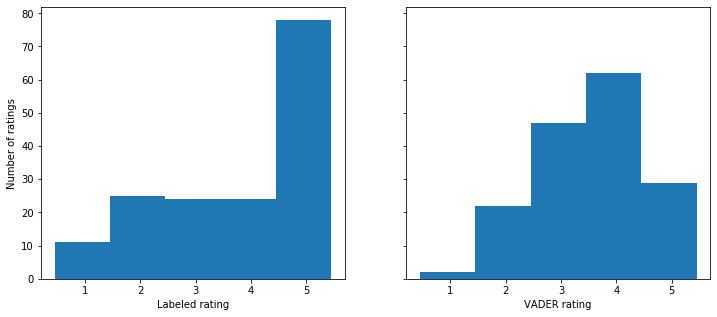

In [35]:
# Let's plot the VADER data continuously as well
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
bins = np.arange(1,7,1)-0.55
ax[0].hist(labeled_rating, bins=bins)
# ax.set_xlim(-3, 3)
ax[0].set_xlabel(r'Labeled rating')
ax[0].set_ylabel(r'Number of ratings')
ax[1].set_xlabel(r'VADER rating')

# Now plot the VADER data
ax[1].hist(vader_rating_float, bins=bins)
# ax[1].set_xlim(0.5, 5.5)
plt.show()

Text(0, 0.5, 'Number of ratings')

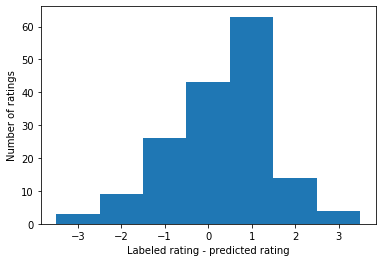

In [36]:
# Plot histogram of difference between "true" and predicted
bins = np.arange(-3,5,1)-0.5
ax = only_labeled['rate_diff'].plot.hist(bins=bins)
# ax.set_xlim(-3, 3)
ax.set_xlabel(r'Labeled rating - predicted rating')
ax.set_ylabel(r'Number of ratings')

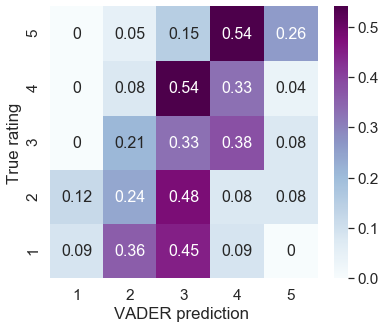

In [37]:
# Let's do something a bit more artful here, a 5x5 confusion matrix?
vader_confusion = confusion_matrix(labeled_rating, vader_rating)
norm_vader_confusion = []
count = 0
for i in vader_confusion:
    norm_vader_confusion.append([])
    norm = sum(i)
    for j in i:
        val = round(j / norm, 2)
        norm_vader_confusion[count].append(val)
    count += 1
norm_vader_confusion = np.array(norm_vader_confusion)

import seaborn as sns

xticks = np.arange(1, 6)
yticks = np.arange(1, 6)

# df_cm = pd.DataFrame(vader_confusion, range(5), range(5))
df_cm = pd.DataFrame(norm_vader_confusion, range(5), range(5))
sns.set(font_scale=1.4) # for label size
fig = plt.figure(figsize=(6,5))
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="BuPu", xticklabels=xticks, yticklabels=yticks) # font size
ax.invert_yaxis()
ax.set_xlabel('VADER prediction ')
ax.set_ylabel('True rating')
plt.savefig("rating_confusion_matrix.png", transparent=True)


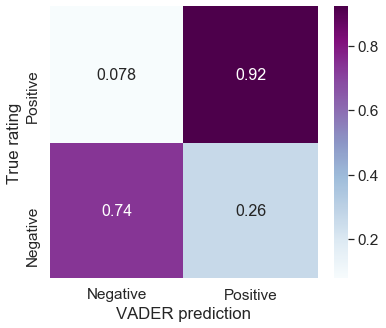

In [38]:
# Make a binned confusion matrix:
bin_vader_confusion = confusion_matrix(bin_labeled_rating, bin_vader_rating)
norm_bin_vader_confusion = []
count = 0
for i in bin_vader_confusion:
    norm_bin_vader_confusion.append([])
    norm = sum(i)
    for j in i:
        val = j / norm
        norm_bin_vader_confusion[count].append(val)
    count += 1
norm_bin_vader_confusion = np.array(norm_bin_vader_confusion)

import seaborn as sns

xticks = ["Negative", "Positive"]
yticks = ["Negative", "Positive"]

df_cm = pd.DataFrame(norm_bin_vader_confusion, [0, 1], [0, 1])
# df_cm = pd.DataFrame(bin_vader_confusion, [0, 1], [0, 1])
sns.set(font_scale=1.4) # for label size
fig = plt.figure(figsize=(6,5))
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="BuPu", xticklabels=xticks, yticklabels=yticks) # font size
ax.invert_yaxis()
ax.set_xlabel('VADER prediction')
ax.set_ylabel('True rating')
plt.savefig("binned_rating_confusion_matrix.png", transparent=True)

In [39]:
# Let's get an F1 score for sentiment
f1_continuous = f1_score(labeled_rating, vader_rating, average='micro')
adjust_labeled_bin = []
adjust_vader_bin = []
# Adjust the labeled rating so that it is 0 or 1
for i in bin_labeled_rating:
    if i > 1:
        adjust_labeled_bin.append(1)
    else:
        adjust_labeled_bin.append(0)
# Adjust the vader rating so that it is 0 or 1
for i in bin_vader_rating:
    if i > 1:
        adjust_vader_bin.append(1)
    else:
        adjust_vader_bin.append(0)
        
        
f1_binned = f1_score(adjust_labeled_bin, adjust_vader_bin)
print(f1_continuous)
print(f1_binned)

0.2654320987654321
0.9281045751633986


## 9. Label sentences with BoW

In [40]:
# Load in the data
product_dfs = []
for i in product_set:
    this_df = pd.read_csv(data_directory + 'review_csvs/' + i + '_review_data.csv')
    this_df.insert(0, 'Type', i)
    product_dfs.append(this_df)
products = pd.concat(product_dfs)

# Add a column for product ID
product_list = []
product_review_count = []
product_id = -1
id_list = []
for i in range(len(products['product'])):
    # If the product isn't yet in the list...
    if products['product'].iloc[i] not in product_list:
        # Add it to the list of distinct products
        product_list.append(products['product'].iloc[i])
        # Add new counter for number of reviews
        product_review_count.append(1)
        # Increment the distinct product id number
        product_id += 1
        
    id_list.append(product_id)
    product_review_count[-1] += 1
    
# Add the product id to the dataframe
products.insert(0, 'id', id_list)

# Print the id and name of the product with the most reviews
most_reviews = max(product_review_count)
most_reviews_id = product_review_count.index(most_reviews)
most_reviews_name = product_list[most_reviews_id]
# print(f'{most_reviews_name} has the most product reviews: {most_reviews}')

# display(products)

In [41]:
# import nltk
# nltk.download('punkt')

In [42]:
# We have to break this data into sentences to train the model
all_sentences = []
sentence_id = []
products.dropna(subset = ["content"], inplace=True)
for i in range(0, len(products['content'])):
    current = tokenize.sent_tokenize(products['content'].iloc[i])
    for j in range(0, len(current)):
        all_sentences.append(current[j])
        sentence_id.append(i)
        
# Confirm that you've split up the sentences
# print(products['content'].iloc[0])
# print("")
# 
# for i in range(0, 5):
#     print(all_sentences[i])
    
# Make a sentences-only dataframe and drop the duplicates
all_sentences = list(dict.fromkeys(all_sentences))

In [43]:
# Let's make and clean a sentence dataframe
s = {'sentence':all_sentences}
sentence_df = pd.DataFrame(s)

# Remove any rows that don't have review data
sentence_df.dropna(subset = ["sentence"], inplace=True)

def bow_clean_tokens(sentence, in_filter):
    
    # Apply gensim filter
    out = gpp.preprocess_string(sentence, in_filter)
    
    # Remove additional undesirable words
    for i in reversed(out):
        if i in custom_remove:
            out.remove(i)
            
    # Remove custom stopwords
    for i in reversed(out):
        if i in stops:
            out.remove(i)
            
    return out

# Apply the cleaning functions
sentence_df['bow_string'] = sentence_df['sentence'].apply(lambda x: bow_clean(x, my_filter))
sentence_df['bow'] = sentence_df['sentence'].apply(lambda x: bow_clean_tokens(x, my_filter))
display(sentence_df)

,sentence,bow_string,bow
0,The fabric/pleather on this chair has torn aft...,fabric pleather chair ha torn month daili,"[fabric, pleather, chair, ha, torn, month, daili]"
1,"It was super comfortable, relatively easy to a...",super comfort rel easi assembl enjoi time func...,"[super, comfort, rel, easi, assembl, enjoi, ti..."
2,I would like to return the product but can’t s...,return product ship especi pandem,"[return, product, ship, especi, pandem]"
3,I never write reviews but this purchase ended ...,write review purchas end bummer,"[write, review, purchas, end, bummer]"
4,Give me my money back without a return Mr. Bez...,monei return bezo send new chair,"[monei, return, bezo, send, new, chair]"
...,...,...,...
345369,I only have it 4 stars for sturdiness because ...,onli star sturdi becaus sit edg bit tip catch ...,"[onli, star, sturdi, becaus, sit, edg, bit, ti..."
345370,Stay centered and your good.,stai center good,"[stai, center, good]"
345371,The cushion it’s self is like a memory foam- s...,cushion self memori foam comfi,"[cushion, self, memori, foam, comfi]"
345372,My husband notice that right away.,husband notic right awai,"[husband, notic, right, awai]"


In [44]:
# Create a vector for each sentence
def get_sentence_vector(sentence):
    sentence_vector = []
    for token in bow_words:
        if token in sentence:
            sentence_vector.append(1)
        else:
            sentence_vector.append(0)
    return sentence_vector

# Get vectors of corpus
sentence_df['bow_vecs'] = sentence_df['bow'].apply(lambda x: get_sentence_vector(x))

In [45]:
# Predict output based on regression
all_x = sentence_df['bow_vecs'].tolist()
assemble = bow_regression.predict(all_x)
sentence_df['assemble'] = assemble
display(sentence_df)

,sentence,bow_string,bow,bow_vecs,assemble
0,The fabric/pleather on this chair has torn aft...,fabric pleather chair ha torn month daili,"[fabric, pleather, chair, ha, torn, month, daili]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,"It was super comfortable, relatively easy to a...",super comfort rel easi assembl enjoi time func...,"[super, comfort, rel, easi, assembl, enjoi, ti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,I would like to return the product but can’t s...,return product ship especi pandem,"[return, product, ship, especi, pandem]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,I never write reviews but this purchase ended ...,write review purchas end bummer,"[write, review, purchas, end, bummer]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,Give me my money back without a return Mr. Bez...,monei return bezo send new chair,"[monei, return, bezo, send, new, chair]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...,...
345369,I only have it 4 stars for sturdiness because ...,onli star sturdi becaus sit edg bit tip catch ...,"[onli, star, sturdi, becaus, sit, edg, bit, ti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345370,Stay centered and your good.,stai center good,"[stai, center, good]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345371,The cushion it’s self is like a memory foam- s...,cushion self memori foam comfi,"[cushion, self, memori, foam, comfi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345372,My husband notice that right away.,husband notic right awai,"[husband, notic, right, awai]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [46]:
# A quick check to make sure the stastics of the ML-labeled data compare well with the labeled data
print( sum(sentence_df['assemble']) / len(sentence_df['assemble']))

0.1409196986455263


In [47]:
# Drop the non-assembly sentences
assembly_sentences = sentence_df[sentence_df.assemble != 0]
display(assembly_sentences)

,sentence,bow_string,bow,bow_vecs,assemble
1,"It was super comfortable, relatively easy to a...",super comfort rel easi assembl enjoi time func...,"[super, comfort, rel, easi, assembl, enjoi, ti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
5,Received chair and all of the parts for assemb...,receiv chair part assembl zipper unfortun litt...,"[receiv, chair, part, assembl, zipper, unfortu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
7,I continued putting the chair together and fig...,continu chair togeth figur try deal zipper later,"[continu, chair, togeth, figur, try, deal, zip...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
8,The chair itself was simple to assemble.,chair simpl assembl,"[chair, simpl, assembl]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
9,However it took a lot of finagling to get the ...,howev took lot finagl zipper togeth requir dab...,"[howev, took, lot, finagl, zipper, togeth, req...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
...,...,...,...,...,...
345310,"Light weight, easy to move around.",light weight easi,"[light, weight, easi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345313,"Modern style, easy to assemble and pretty steady!",modern style easi assembl pretti steadi,"[modern, style, easi, assembl, pretti, steadi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345315,"However, our item arrived with without a screw...",howev item arriv screw thread tabl screw hole ...,"[howev, item, arriv, screw, thread, tabl, scre...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345364,Shipped fast and the feet were super easy to p...,ship fast feet super easi,"[ship, fast, feet, super, easi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


## 10. Perform LDA on assembly sentences

super comf


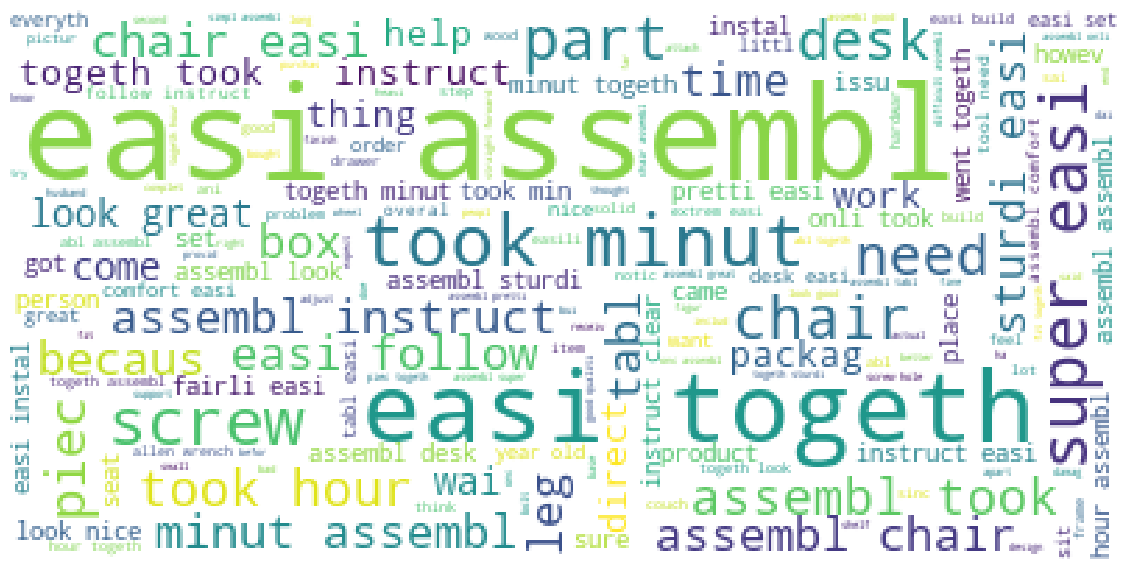

In [48]:
# Let's looks at the text data
from wordcloud import WordCloud

# Gather all words to one string
all_words_string = ""
for i in assembly_sentences['bow']:
    for j in range(0, len(i)):
        all_words_string += i[j] + " "
        
print(all_words_string[0:10])
        
word_cloud = WordCloud(background_color="white")
word_cloud.generate(all_words_string)

fig = plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [49]:
# Let's get the frequency of our BoW vocab for all the sentences
frequency_dictionary = dict.fromkeys(bow_words, 0)
for i in assembly_sentences['bow']:
    for j in range(0, len(i)):
        if i[j] in bow_words:
            frequency_dictionary[i[j]] += 1
            
# Let's grab the 10 most common bow items
top_ten_words = []
top_ten_count = []

# Get a list of the frequencies
print(len(bow_words))
word_list = bow_words.copy()
frequency_list = list(frequency_dictionary.values())

# Get top 10 values
for i in range(0, 10):
    # Get the current max
    max_count = max(frequency_list)
    # Get the current index of the max
    index = frequency_list.index(max_count)
    # Add it to our lists
    top_ten_words.append(word_list[index])
    top_ten_count.append(max_count)
    # Remove it from the frequency list and word list
    word_list.remove(word_list[index])
    frequency_list.remove(max_count)
    
print(top_ten_words)
print(top_ten_count)

313
['assembl', 'easi', 'togeth', 'took', 'instruct', 'chair', 'minut', 'screw', 'desk', 'piec']
[26399, 21891, 15188, 6070, 5911, 5133, 4744, 4593, 3417, 3190]


In [50]:
# We can get a much larger vocab from the total data set (BoW)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate the count vectorizer 
# -n-grams of length 1 and 2
# -ignore words that are in more than 50% of sentences
# -ignore words that are in fewer than 0.5% of sentences
# cv = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=0.005)
# min_occur = 2
# max_occur = 0.5
# ngrams = (1, 1)
min_occur = 0.005
max_occur = 0.5
ngrams = (1, 1)

# Instantiate each vectorizer
lda_cv = CountVectorizer(ngram_range=ngrams, max_df=max_occur, min_df=min_occur)
lda_tfidf = TfidfVectorizer(ngram_range=ngrams, max_df=max_occur, min_df=min_occur)

# Make the x train a list
assembly_sentence_list = assembly_sentences['bow_string'].tolist()

# Feed our sentences to the count vectorizer
lda_count_data = lda_cv.fit_transform(assembly_sentence_list)
lda_tfidf_count = lda_tfidf.fit_transform(assembly_sentence_list)

# Print the number of words being used
print(len(lda_cv.get_feature_names()))
print(len(lda_tfidf.get_feature_names()))
# A list of the words
lda_bow_words = lda_cv.get_feature_names()
lda_tfidf_words = lda_tfidf.get_feature_names()
# A dataframe of the complete corpus
lda_cv_df = pd.DataFrame(lda_count_data.toarray(), columns = lda_cv.get_feature_names())
display(lda_cv_df)
tfidf_df = pd.DataFrame(tfidf_count.toarray(), columns = tfidf_words)
display(tfidf_df)

224
224


,abl,actual,adjust,align,allen,alon,alreadi,ani,anoth,apart,...,wasn,went,wheel,wobbl,wood,work,worth,wrench,wrong,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,100,abl,absolut,actual,adjust,afford,air,alreadi,amaz,amazon,...,went,wheel,wife,wobbl,won,wood,work,worth,wrap,year
0,0.0,0.0,0.0,0.0,0.328016,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.37365,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.246715,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.217371,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.352050,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
384,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [51]:
# Let's export my count vectorizer
joblib.dump(lda_cv, "../models/lda_cv.pkl")

['../models/lda_cv.pkl']

In [52]:
# Now let's run LDA and see what we get out
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 3
n_words = 15

# # Use this for BoW vocab (from train set)
# use_count = count_data
# use_words = bow_words
# use_vectorizer = cv
# # Use this for tfidf vocab (from train set)
# use_count = tfidf_count
# use_words = tfidf_words
# use_vectorizer = tfidf
# Use the BoW model trained on all of the review data
use_count = lda_count_data
use_words = lda_bow_words
use_vectorizer = lda_cv
# # Use this for tf-idf trained on all review data
# use_count = lda_tfidf_count
# use_words = lda_tfidf_words
# use_vectorizer = lda_tfidf

# lda = LDA(n_components=n_topics, n_jobs=1, random_state=1, doc_topic_prior=1./n_topics, topic_word_prior=0.25/n_topics)
lda = LDA(n_components=n_topics, n_jobs=1, random_state=1)
lda_model = lda.fit(use_count)
lda_log_likelihood = lda.score(use_count)
lda_perplexity = lda.perplexity(use_count)
print(lda_log_likelihood)
print(lda_perplexity)
for topic_idx, topic in enumerate(lda_model.components_):
    print("Topic ", topic_idx, ":")
    print(" ".join([use_words[i] for i in topic.argsort()[:-n_words - 1:-1]]))

-1035483.4748753038
114.02414439352391
Topic  0 :
took minut togeth hour chair onli time min instal person help drill abl set seat
Topic  1 :
togeth instruct screw piec need part box came hole tool desk leg come everyth clear
Topic  2 :
easi togeth sturdi look great chair super nice good comfort desk tabl pretti qualiti price


In [53]:
# Topic-Keyword Matrix
norm_components = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
# df_topic_keywords = pd.DataFrame(norm_components)
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = use_vectorizer.get_feature_names()
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
df_topic_keywords.index = topicnames
# View
display(df_topic_keywords)

,abl,actual,adjust,align,allen,alon,alreadi,ani,anoth,apart,...,wasn,went,wheel,wobbl,wood,work,worth,wrench,wrong,year
Topic0,718.266270,48.187202,506.260024,22.907323,426.282609,353.060673,0.644220,1.729551,148.604893,1.377180,...,5.925446,0.362345,162.267036,19.329357,0.367208,244.364810,122.961168,529.862752,1.456542,541.303838
Topic1,488.383134,213.937718,0.353554,268.749194,0.375096,0.568246,351.003993,830.591535,126.027260,355.133813,...,644.722568,741.132006,18.052300,173.570408,457.220655,69.052548,81.008530,0.794162,295.195108,0.347816
Topic2,0.350596,68.875081,14.386422,0.343483,0.342295,0.371082,0.351787,1.678913,0.367847,135.489007,...,0.351986,0.505648,145.680664,65.100235,244.412138,614.582643,137.030302,0.343086,0.348350,0.348346


In [54]:
# Let's save our lda model
lda_out = '../models/lda_model.pkl'
joblib.dump(lda_model, lda_out)

['../models/lda_model.pkl']

In [55]:
# Visualize
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

# IMPORTANT: the topic numbers here do NOT match the real topic numbers
# check by setting gamma=1 and looking at top list of words
vis = sklearn_lda.prepare(lda_model, use_count, use_vectorizer)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)


In [56]:
import warnings
warnings.simplefilter('ignore')

/Users/kolbt/insight/insight_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [57]:
# We can feed our model a sentence and see how it categorizes it
lda_sentences = ["It only took me 20 minutes to assemble!",
                 "Came with bad and missing parts, couldn't put it together.",
                 "The allen wrench needed for assembly is included",
                 "The parts were very high quality and the table was really sturdy when I got it assembled",
                 "Really quick and painless, and the tools came right in the box!"]

lda_topic_labels = ["Time",
                    "Parts/Tools",
                    "Parts/Tools",
                    "Parts/Tools, Quality",
                    "Time, Parts/Tools"]

# Preprocess the sentences
lda_sentences_clean = []
count = 0
for i in lda_sentences:
    # Clean the sentence
    lda_sentences_clean.append(bow_clean_tokens(i, my_filter))
    # Compute the category probability for each word in the clean sentence
    word_probabilities = lda_model.transform(use_vectorizer.transform(lda_sentences_clean[-1]))
    sentence_probability = [*map(np.mean, zip(*word_probabilities))]
    print(i)
    print(lda_sentences_clean[-1])
    print(sentence_probability)
    print("Intended topic: ", lda_topic_labels[count])
    print("Majority topic: ", sentence_probability.index(max(sentence_probability)))
    print("")
    count += 1


It only took me 20 minutes to assemble!
['onli', 'took', 'minut', 'assembl']
[0.5827437842297059, 0.20892255210834798, 0.20833366366194622]
Intended topic:  Time
Majority topic:  0

Came with bad and missing parts, couldn't put it together.
['came', 'bad', 'miss', 'part', 'couldn', 'togeth']
[0.2862041428449466, 0.4550442748361092, 0.2587515823189443]
Intended topic:  Parts/Tools
Majority topic:  1

The allen wrench needed for assembly is included
['allen', 'wrench', 'need', 'assembl', 'includ']
[0.4029505477518671, 0.39670771348341766, 0.20034173876471523]
Intended topic:  Parts/Tools
Majority topic:  0

The parts were very high quality and the table was really sturdy when I got it assembled
['part', 'high', 'qualiti', 'tabl', 'sturdi', 'got', 'assembl']
[0.28234723421046215, 0.2911431465426113, 0.42650961924692654]
Intended topic:  Parts/Tools, Quality
Majority topic:  2

Really quick and painless, and the tools came right in the box!
['quick', 'painless', 'tool', 'came', 'right', 'b

## Guided LDA to refine categories

In [58]:
%%capture
# Check to see what words are in my vocab
for word in use_words:
    print(word)

In [59]:
# # Guide LDA to make categories for: tools used, time to assemble, quality, and furniture type [tool, time, quality, chair]
# import guidedlda

# # seed_topic_list = [["chair", "tabl", "desk", "mattress", "bed", "bedroom", "bench"], 
# #                    ["tool", "drill", "allen", "wrench", "screwdriv"],
# #                    ["leg", "fit", "piec", "screw", "bolt", "part"],
# #                    ["time", "min", "minut", "fast", "took", "hour", "quick"],
# #                    ["qualiti", "sturdi", "scratch", "solid", "wobbl"]]

# seed_topic_list = [["tool", "drill", "allen", "wrench", "screwdriv", "leg", "fit", "piec", "screw", "bolt", "part"],
#                    ["time", "min", "minut", "fast", "took", "hour", "quick"],
#                    ["qualiti", "sturdi", "scratch", "solid", "wobbl"]]

# # Check to make sure words are in vocabulary
# for i in seed_topic_list:
#     remove_words = []
#     for j in i:
#         if j not in use_words:
#             print(j)
#             remove_words.append(j)
#     for j in reversed(remove_words):
#         i.remove(j)
            
            
# # Create a dictionary of vocab
# word2id = dict((v, idx) for idx, v in enumerate(use_words))

# guided_model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), n_iter=100, random_state=seed, refresh=20)
# seed_topics = {}
# for t_id, st in enumerate(seed_topic_list):
#     for word in st:
#         seed_topics[word2id[word]] = t_id
# guided_model.fit(use_count, seed_topics=seed_topics, seed_confidence=0.15)

In [60]:
# n_top_words = 15
# topic_word = guided_model.topic_word_
# for i, topic_dist in enumerate(topic_word):
#      topic_words = np.array(use_words)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#      print('Topic {}: {}'.format(i, ' '.join(topic_words)))